In [233]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [234]:
# function for data loading
def load_data_fashion(path, kind = "train"):
    import os
    import gzip
    import numpy as np

    """Load Fashion-MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(),dtype=np.uint8,offset=16).reshape(len(labels), 784)

    return images, labels

In [235]:
# load data using above functin
X_train, y_train = load_data_fashion("fashion", kind = "train")
X_test, y_test = load_data_fashion("fashion", kind = "t10k")


In [236]:
# view data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [237]:
# create dataset class
class MyDataset(Dataset):
    def __init__(self, image_path, kind, transforms = None):
        
        self.transforms = transforms
        self.images, self.labels = load_data_fashion(image_path, kind = kind)
        
    def __getitem__(self, index):
        img = self.images[index]
        img = torch.tensor(img, dtype = torch.float32)
        img = img/255
        label = self.labels[index]

        if self.transforms is not None:
            img = self.transforms(img)
        label = torch.tensor(label, dtype = torch.long)
        return img, label
    
    def __len__(self):
        return len(self.images)

In [238]:
# pass data from dataset to dataloader for training and testing
train_dataset = MyDataset("fashion", kind = "train")
test_dataset = MyDataset("fashion", kind = "t10k")

In [239]:
# view data
print(len(train_dataset))
print(len(test_dataset))

60000
10000


### create validation set

In [240]:
from torch.utils.data.dataset import random_split

# split data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# view data
print(len(train_dataset))
print(len(val_dataset))

48000
12000


In [241]:
# create data loaders
train_loader = DataLoader(dataset = train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 64, shuffle = True)

In [242]:
# create model class
class PytorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.big_layer = nn.Sequential(nn.Linear(num_features, 300),
                                       nn.ReLU(),
                                       nn.Linear(300, 100),
                                       nn.ReLU(),
                                       nn.Linear(100, 50),
                                       nn.ReLU(),
                                       nn.Linear(50, num_classes))
    
    def forward(self, x):
        # flatten before returning
        flatten = nn.Flatten(start_dim = 1)
        x = flatten(x)
        logits = self.big_layer(x)
        return logits

In [243]:
# device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [244]:
# insantiate model
model = PytorchMLP(784, 10).to(device)

In [245]:
# accuracy function
def compute_accuracy(model, dataloader):
    model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)
        with torch.inference_mode():
            logits = model(features)

        prediction = torch.argmax(logits, dim = 1)
        compare = labels == prediction
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples    

In [246]:
# define training loop
optimizer = torch.optim.SGD(model.parameters(), lr=0.007)

epochs = 30

loss_list = []
train_acclist, val_acclist = [], []
for epoch in range(epochs):
    model.train()

    for batchidx, (features, labels) in enumerate(train_loader):
        features = features.to(device)  # Move features tensor to the same device as the model

        logits = model(features)

        loss = F.cross_entropy(logits, labels.to(device))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if not batchidx % 250:
            print(
                f"Epoch: {epoch + 1:03d}/{epochs:03d}"
                f" | Batch: {batchidx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())
        
        loss = F.cross_entropy(logits, labels.to(device))
    
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Accuracy: {train_acc * 100:.2f}% | Val Accuracy: {val_acc * 100:.2f}")
    train_acclist.append(train_acc)
    val_acclist.append(val_acc)



Epoch: 001/030 | Batch: 000/750 | Train Loss: 2.29
Epoch: 001/030 | Batch: 250/750 | Train Loss: 2.27
Epoch: 001/030 | Batch: 500/750 | Train Loss: 2.14
Train Accuracy: 40.69% | Val Accuracy: 40.30
Epoch: 002/030 | Batch: 000/750 | Train Loss: 1.82
Epoch: 002/030 | Batch: 250/750 | Train Loss: 1.35
Epoch: 002/030 | Batch: 500/750 | Train Loss: 1.16
Train Accuracy: 61.96% | Val Accuracy: 60.88
Epoch: 003/030 | Batch: 000/750 | Train Loss: 0.89
Epoch: 003/030 | Batch: 250/750 | Train Loss: 0.98
Epoch: 003/030 | Batch: 500/750 | Train Loss: 0.79
Train Accuracy: 67.91% | Val Accuracy: 67.41
Epoch: 004/030 | Batch: 000/750 | Train Loss: 0.72
Epoch: 004/030 | Batch: 250/750 | Train Loss: 0.64
Epoch: 004/030 | Batch: 500/750 | Train Loss: 0.60
Train Accuracy: 72.83% | Val Accuracy: 72.01
Epoch: 005/030 | Batch: 000/750 | Train Loss: 0.65
Epoch: 005/030 | Batch: 250/750 | Train Loss: 0.73
Epoch: 005/030 | Batch: 500/750 | Train Loss: 0.79
Train Accuracy: 76.60% | Val Accuracy: 75.54
Epoch: 006

In [247]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)
print(f"Train Accuracy: {train_acc * 100:.2f}% | Val Accuracy: {val_acc * 100:.2f}% | Test Accuracy: {test_acc * 100:.2f}%")


Train Accuracy: 87.50% | Val Accuracy: 85.97% | Test Accuracy: 85.34%


(None,)

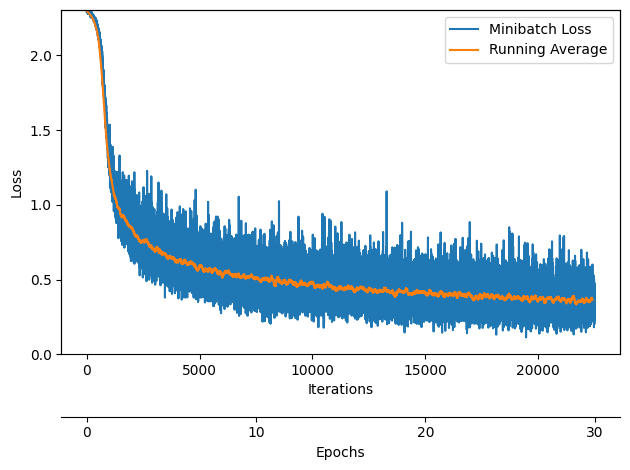

In [251]:
from helper_plotting import plot_training_loss, plot_accuracy

plot_training_loss(minibatch_loss_list=loss_list, 
                   num_epochs=epochs,
                   iter_per_epoch=len(loss_list)//epochs),

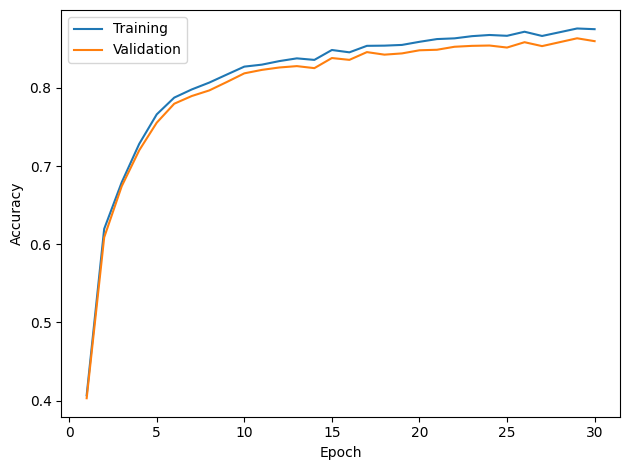

In [258]:
# turn train_acclist and val_acclist using .cpu
train_acclist = [x.cpu() for x in train_acclist]
val_acclist = [x.cpu() for x in val_acclist]

plot_accuracy(train_acc_list=train_acclist, valid_acc_list=val_acclist)